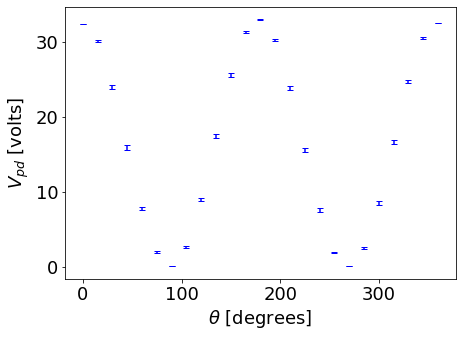

In [2]:
import numpy as np # only need this once per program

file_name = 'Calibration_650nm.csv'               # replace with the name of your csv data file

file_folder = 'C:\\Users\\Benjamín\\Documents\\Datos\\Data_column\\'                                  # use this if your data file is in the same folder as your python program

#file_folder = '/Users/nfortune/data'             # use this if data file is in a folder called 'data' 
                                                  # inside the folder 'nfortune' within the 'Users' directory 
                                                  # such as when using the Jupyter webserver jove.smith.edu
                                                  # this is called 'absolute addressing'

#file_folder = 'data_subfolder/'                  # you can use this if data file is in a _subfolder_ called 'data_subfolder'
                                                  # this is called 'relative addressing'
data_file = file_folder + file_name

angle, V_pd, V_pd_error  = np.loadtxt(data_file, delimiter = ',', skiprows = 1, usecols = (0, 1, 2), unpack = True)

%matplotlib inline

import matplotlib as mpl
from matplotlib import pyplot as plt #this is the traditional method

mpl.rc('xtick', labelsize = 18)      #use 18 point font for numbering on x axis
mpl.rc('ytick', labelsize = 18)      #use 18 point font for numbering on y axis

plt.figure(figsize = (7,5))          #specify figure size as 7 x 5 inches
                                     #for default size, type plt.figure() 
                                             
plt.xlabel(r"$\theta$ [degrees]", fontsize = 18) #label axis (using LaTeX commands)
plt.ylabel(r"$V_{pd}$ [volts]", fontsize = 18)   #use 18 point font for label text

plt.errorbar(angle, V_pd,  
    xerr=None, yerr=V_pd_error, 
    linestyle = 'none', 
    color = 'blue',  
    capsize = 3, capthick = 1)
    
plt.show()    


In [33]:
import numpy as np # only need this once per program

file_name = 'Calibration_650nm.csv'               # replace with the name of your csv data file

file_folder = 'C:\\Users\\Benjamín\\Documents\\Datos\\Data_column\\'                                  # use this if your data file is in the same folder as your python program

#file_folder = '/Users/nfortune/data'             # use this if data file is in a folder called 'data' 
                                                  # inside the folder 'nfortune' within the 'Users' directory 
                                                  # such as when using the Jupyter webserver jove.smith.edu
                                                  # this is called 'absolute addressing'

#file_folder = 'data_subfolder/'                  # you can use this if data file is in a _subfolder_ called 'data_subfolder'
                                                  # this is called 'relative addressing'
data_file = file_folder + file_name

angle, V_pd, V_pd_error  = np.loadtxt(data_file, delimiter = ',', skiprows = 1, usecols = (0, 1, 2), unpack = True)

# measured uncertainties
delta_V0 = 0.020           # mV, after averaging
delta_V1 = 0.014           # mV, after averaging
delta_theta = 0.5 * np.pi / 180  # 0.5 degrees, in radians

# initial guess for polarization models 
V0 = 30.0    #initial guess, in mV
V1 = 0.02    #initial guess, in mV



theta = angle * np.pi / 180    # convert from degrees to radians
theta0 = -2.0 * np.pi / 180   #initial guess for offset angle of 2 degree, in radians

initial_guess = np.array([V0, theta0, V1])
initial_error = np.array([delta_V0, delta_theta, delta_V1])
old_fit = np.copy(initial_guess)  # save a copy to compare new with old

def photodiode_error(phi_array, delta_V_0, delta_phi, delta_V_1, V_0, phi_0):  
    V_0_error= (delta_V_0 / V_0) * (np.cos(phi_array - phi_0))**2
    phi_error = (delta_phi) * (2 * np.cos(phi_array- phi_0) * np.sin(phi_array - phi_0))
    V_1_error= (delta_V_1 / V_0) 
    fractional_error = np.sqrt(V_0_error **2 + phi_error **2 + V_1_error **2)
    return fractional_error * V_0

estimated_error = photodiode_error(theta, delta_V0, delta_theta, delta_V1, 
    V0, theta0)    #propagate uncertainty using initial values

#print(estimated_error)

ER_rel = []
for i in estimated_error:
    ER_rel.append(float(i))

#print(ER_rel)

def polarization_model( phi_array, V_0, phi_0, V_1):
    return V_0 * (1 + np.cos(2 * (phi_array - phi_0)))/2 + V_1

# load curve_fit routine from scipy
from scipy.optimize import curve_fit # import method used here

# alternative method (as recommended in https://docs.scipy.org/doc/scipy/reference.api.html)
from scipy import optimize
#fit, covariance = optimize.curve_fit(...)

#run curve_fit for polarization_model
fit, covariance = optimize.curve_fit(polarization_model, theta, V_pd,
                            p0 = initial_guess,
                            sigma = estimated_error, absolute_sigma = True, )

error = np.sqrt(np.diag(covariance))

print(old_fit)
print(fit)

old_fit = np.copy(fit)

print()
print('V_0    = ','{:.3f}'.format(fit[0]), '±', '{:.3f}'.format(error[0]), ' mV')
print('V_1 = ','{:.4f}'.format(fit[2]), '±', '{:.3f}'.format(error[2]), ' mV')
print('theta_0  = ','{:.4f}'.format(fit[1]), '±', '{:.4f}'.format(error[1]), 'radian')
print('       = ','{:.4f}'.format(fit[1]*180/np.pi), '±', '{:.4f}'.format(error[1]*180/np.pi), 'degrees')


[ 3.0000000e+01 -3.4906585e-02  2.0000000e-02]
[ 3.26316198e+01 -2.01036800e-02  2.31376078e-02]

V_0    =  32.632 ± 0.024  mV
V_1 =  0.0231 ± 0.016  mV
theta_0  =  -0.0201 ± 0.0018 radian
       =  -1.1519 ± 0.1022 degrees


In [37]:
from scipy.stats import chi2

new_initial_values = np.array([fit[0], fit[1], fit[2]])

estimated_error = photodiode_error(theta, delta_V0, delta_theta, delta_V1, 
    fit[0], fit[1]) # propagate error using new values for V0, etc

fit, covariance = curve_fit(polarization_model, theta, V_pd, 
                            p0 = new_initial_values, 
                            sigma = estimated_error, absolute_sigma = True)

error = np.sqrt(np.diag(covariance))

print(old_fit)
print(fit)

old_fit = np.copy(fit)

V_pd_model = polarization_model(theta, fit[0], fit[1], fit[2])
residual = V_pd - V_pd_model

data_uncertainty = photodiode_error(theta, delta_V0, delta_theta, delta_V1, fit[0], fit[1])

chisq = sum((residual/ data_uncertainty)**2) #typo corrected
degrees_of_freedom = len(residual) - len(initial_guess)
reduced_chisq = chisq / degrees_of_freedom  # this should be close to one
CDF = chi2.cdf(chisq, degrees_of_freedom)   # this should be close to 50 percent

print('chi-square         = ',chisq)
print('degrees of freedom = ',degrees_of_freedom)
print('reduced chi-square = ',reduced_chisq)
print('fractional probability of chisq ≤', chisq, 'for ', degrees_of_freedom, 'dof is', CDF)

[ 3.26292677e+01 -1.99844233e-02  2.24749046e-02]
[ 3.26292676e+01 -1.99844033e-02  2.24749427e-02]
chi-square         =  320.3152446093329
degrees of freedom =  22
reduced chi-square =  14.55978384587877
fractional probability of chisq ≤ 320.3152446093329 for  22 dof is 1.0


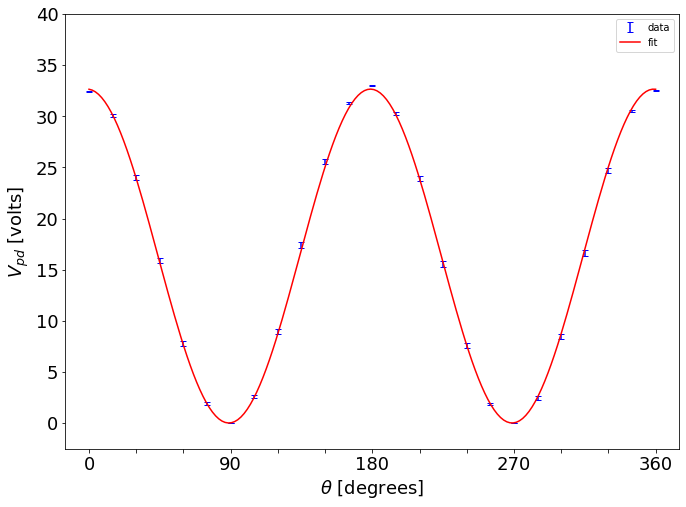

In [36]:
plt.figure(figsize = (11,8))                  #specify figure size as 7 x 5 inches
                                             #for default size, type plt.figure() 
                                             
plt.xlabel(r"$\theta$ [degrees]", fontsize = 18) #label axis (using LaTeX commands)
plt.ylabel(r"$V_{pd}$ [volts]", fontsize = 18)   #use 18 point font for label text

# plot the data as before in blue
plt.errorbar(angle, V_pd,  
    xerr=None, yerr=V_pd_error, 
    linestyle = 'none', 
    color = 'blue',  
    capsize = 3, capthick = 1, label = "data")

#create curve showing fit to data 
angle_fit = np.linspace(0, 360, 180)
theta_fit = angle_fit * np.pi / 180
V_pd_fit = polarization_model(theta_fit, fit[0], fit[1], fit[2])

#plot the curve fit in red
plt.errorbar(angle_fit, V_pd_fit, xerr = None, yerr = None, color = 'red', label = 'fit' )
plt.xlim(-15, 375)
plt.ylim(-2.5, 40)
plt.xticks([0,   30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360], 
           ('0', '', '', 90,  '',  '', 180,  '',  '', 270,  '',  '', 360))
plt.legend(loc = 'best')
    
plt.show()  

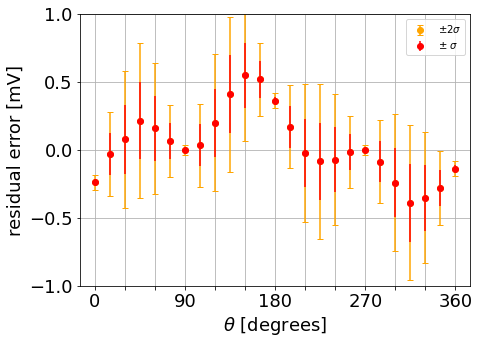

In [38]:
plt.figure(figsize = (7,5))                  #specify figure size as 7 x 5 inches
                                             #for default size, type plt.figure() 
                                             
plt.xlabel(r"$\theta$ [degrees]", fontsize = 18) #label axis (using LaTeX commands)
plt.ylabel(r"residual error [mV]", fontsize = 18)   #use 18 point font for label text

# plot the data as before in blue

plt.errorbar(angle, residual,  
    xerr=None, yerr=2 * data_uncertainty, 
    linestyle = 'none', 
    color = 'orange',  fmt = 'o',
    capsize = 3, capthick = 1, label = "$\pm2\sigma$") 
plt.errorbar(angle, residual,  
    xerr=None, yerr=data_uncertainty, 
    linestyle = 'none', 
    color = 'red',  fmt = 'o',
    capsize = 0, capthick = 1, label = "$\pm\  \sigma$")


plt.xlim(-15, 375)
plt.ylim(-1, 1)
plt.xticks([0,   30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360], 
           ('0', '', '', 90,  '',  '', 180,  '',  '', 270,  '',  '', 360))
plt.legend(loc = 'best')
plt.grid(1)  
plt.show()  

In [39]:
from scipy.stats import chi2          # 'chi-square' goodness of fit calculation

chisq = sum((residual/ data_uncertainty)**2)  # typo corrected 2/1/2019
degrees_of_freedom = len(residual) - len(initial_guess)
reduced_chisq = chisq / degrees_of_freedom  # this should be close to one
CDF = chi2.cdf(chisq, degrees_of_freedom)   # this should be close to 50 percent

print('chi-square         = ',chisq)
print('degrees of freedom = ',degrees_of_freedom)
print('reduced chi-square = ',reduced_chisq)
print('fractional probability of chisq ≤', chisq, 'for ', degrees_of_freedom, 'dof is', CDF)

chi-square         =  320.3152446093329
degrees of freedom =  22
reduced chi-square =  14.55978384587877
fractional probability of chisq ≤ 320.3152446093329 for  22 dof is 1.0


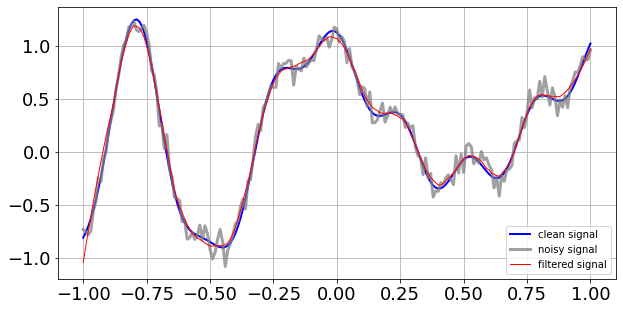

In [40]:
%matplotlib inline 
import matplotlib.pyplot as plt
# import numpy as np
from numpy import sin, cos, pi, linspace, absolute, array, savetxt  # functions needed to generate clean signal
from numpy.random import randn                             # function needed to add noise
from scipy.signal import savgol_filter                 # import Savitzky-Golay low pass filter for data smoothing

# Generate a noisy signal to be filtered.
t = linspace(-1, 1, 201)
delta_t = absolute(t[1] - t[0]) 

x = (sin(2 * pi * 0.75 * t*(1-t) + 2.1) + 0.1*sin(2 * pi * 1.25 * t + 1) +
    0.18*cos(2 * pi * 3.85 * t))
xn = x + randn(len(t)) * 0.08

window_width = 25                              # number of points over which data is fit and smoothed
polynomial_order = 2                     # order of polynominal used to fit data (must be less than window_width)

smoothed_data   = savgol_filter(xn, window_width, polynomial_order)                             #smooth data
data_derivative = savgol_filter(xn, window_width, polynomial_order, deriv = 1, delta = delta_t) #take 1st derivative

# Make the plot.
plt.figure(figsize=(10,5))
plt.plot(t,x, 'blue', linewidth = 2, label = 'clean signal')
plt.plot(t, xn, 'grey', linewidth=3, alpha=0.75, label = 'noisy signal')
plt.plot(t, smoothed_data, 'red', linewidth=1, label = 'filtered signal')
plt.legend(loc='best')
plt.grid(True)
plt.show()

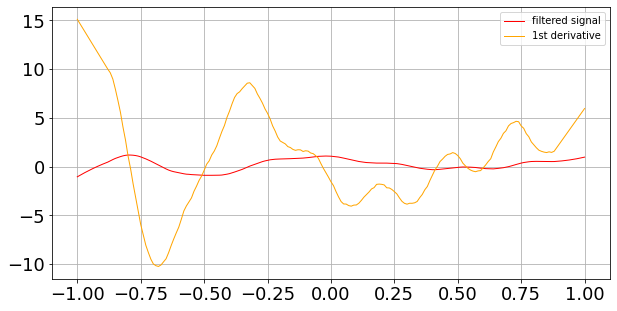

In [41]:
plt.figure(figsize=(10,5))
#plt.plot(t,x, 'blue', linewidth = 2, label = 'clean signal')
plt.plot(t, smoothed_data, 'red', linewidth=1, label = 'filtered signal')
plt.plot(t, data_derivative, 'orange', linewidth=1, label = '1st derivative')
plt.legend(loc='best')
plt.grid(True)
plt.show()

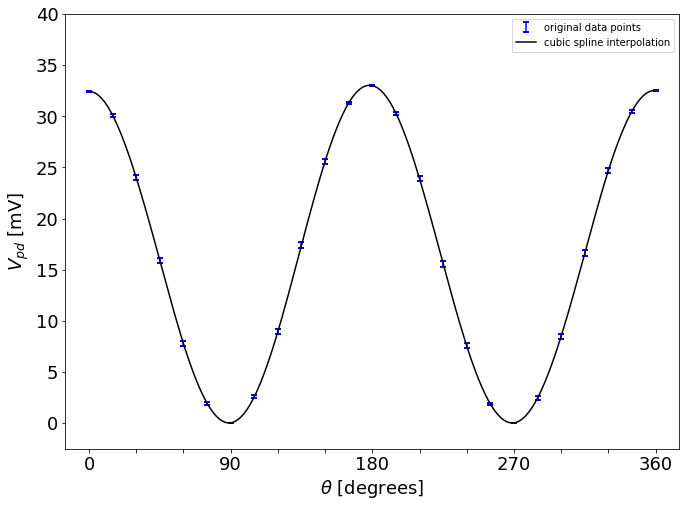

In [42]:
# from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline

mpl.rc('xtick', labelsize = 18)                  #use 18 point font for numbering on x axis
mpl.rc('ytick', labelsize = 18)                  #use 18 point font for numbering on y axis

interpolating_function = interp1d(angle, V_pd, kind = 'cubic')

interpolated_data = interpolating_function(angle_fit)

plt.figure(figsize = (11,8))                  #specify figure size as 7 x 5 inches
                                             #for default size, type plt.figure() 
                                             
plt.xlabel(r"$\theta$ [degrees]", fontsize = 18) #label axis (using LaTeX commands)
plt.ylabel(r"$V_{pd}$ [mV]", fontsize = 18)   #use 18 point font for label text




#plt.errorbar(angle_fit, V_pd_fit, xerr = None, yerr = None, color = 'red', label = 'fit to physical model' )
plt.errorbar(angle, V_pd,  
    xerr=None, yerr=data_uncertainty, 
    linestyle = 'none', 
    color = 'blue',  
    capsize = 3, capthick = 2, label = "original data points")

plt.errorbar(angle_fit, interpolated_data, xerr = None, yerr = None, color = 'black', label = 'cubic spline interpolation')


plt.xlim(-15, 375)
plt.ylim(-2.5, 40)
plt.xticks([0,   30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360], 
           ('0', '', '', 90,  '',  '', 180,  '',  '', 270,  '',  '', 360))
plt.legend(loc = 'best')
    
plt.show() 

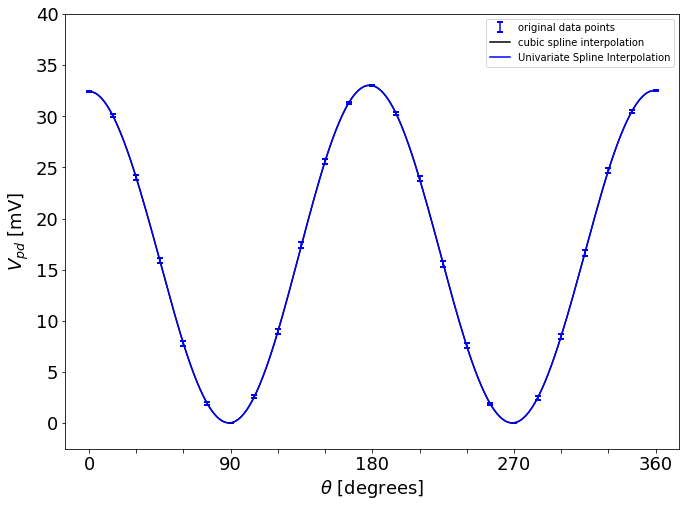

In [43]:
InterpolatingUnivariateSpline_function = InterpolatedUnivariateSpline( angle, V_pd, k = 4)
IUS_interpolated_data = InterpolatingUnivariateSpline_function(angle_fit)

plt.figure(figsize = (11,8))                  #specify figure size as 7 x 5 inches
                                             #for default size, type plt.figure() 
                                             
plt.xlabel(r"$\theta$ [degrees]", fontsize = 18) #label axis (using LaTeX commands)
plt.ylabel(r"$V_{pd}$ [mV]", fontsize = 18)   #use 18 point font for label text




#plt.errorbar(angle_fit, V_pd_fit, xerr = None, yerr = None, color = 'red', label = 'fit to physical model' )
plt.errorbar(angle, V_pd,  
    xerr=None, yerr=data_uncertainty, 
    linestyle = 'none', 
    color = 'blue',  
    capsize = 3, capthick = 2, label = "original data points")

plt.errorbar(angle_fit, interpolated_data, xerr = None, yerr = None, color = 'black', label = 'cubic spline interpolation')


plt.errorbar(angle_fit, interpolated_data, xerr = None, yerr = None, color = 'blue', label = 'Univariate Spline Interpolation')


plt.xlim(-15, 375)
plt.ylim(-2.5, 40)
plt.xticks([0,   30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360], 
           ('0', '', '', 90,  '',  '', 180,  '',  '', 270,  '',  '', 360))
plt.legend(loc = 'best')
    
plt.show() 

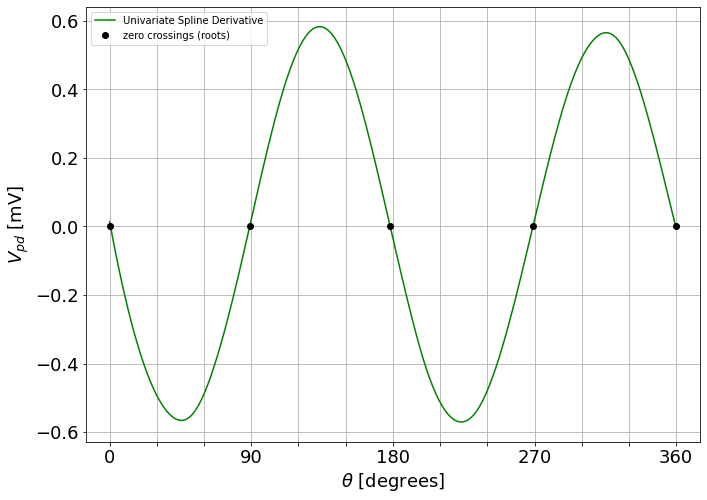

In [44]:
spline_derivative_function = InterpolatingUnivariateSpline_function.derivative()

data_derivative = spline_derivative_function(angle_fit)
zero_crossings = InterpolatingUnivariateSpline_function.derivative().roots()
zero_values = np.zeros(len(zero_crossings))
extrema_values = InterpolatingUnivariateSpline_function(zero_crossings)

plt.figure(figsize = (11,8))                  #specify figure size as 7 x 5 inches
                                             #for default size, type plt.figure() 
                                             
plt.xlabel(r"$\theta$ [degrees]", fontsize = 18) #label axis (using LaTeX commands)
plt.ylabel(r"$V_{pd}$ [mV]", fontsize = 18)   #use 18 point font for label text

# plt.errorbar(angle_fit, interpolated_data, xerr = None, yerr = None, color = 'blue', label = 'Univariate Spline Interpolation')
plt.errorbar(angle_fit, data_derivative, xerr = None, yerr = None, color = 'green', label = 'Univariate Spline Derivative')
plt.errorbar(zero_crossings, zero_values, xerr = None, yerr = None, fmt = 'o', color = 'black', label = 'zero crossings (roots)')


plt.xlim(-15, 375)
#plt.ylim(-10, 40)
plt.xticks([0,   30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360], 
           ('0', '', '', 90,  '',  '', 180,  '',  '', 270,  '',  '', 360))
plt.legend(loc = 'best')
plt.grid(True)
plt.show() 

33.0


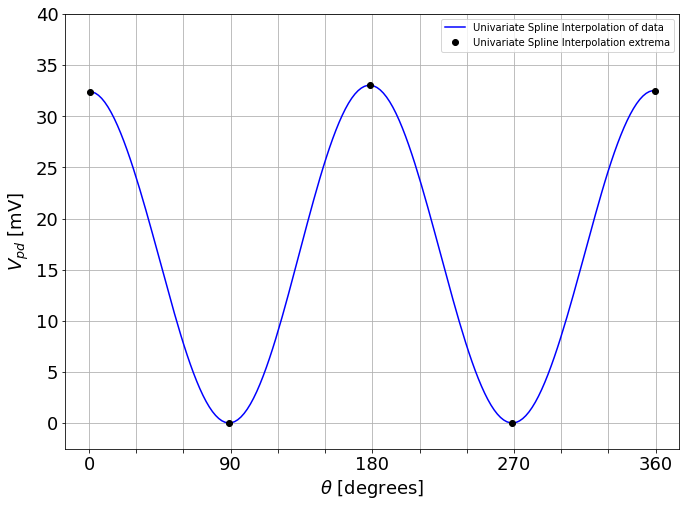

In [45]:
peak_value = V_pd.max()
print(peak_value)

plt.figure(figsize = (11,8))                  #specify figure size as 7 x 5 inches
                                             #for default size, type plt.figure() 
                                             
plt.xlabel(r"$\theta$ [degrees]", fontsize = 18) #label axis (using LaTeX commands)
plt.ylabel(r"$V_{pd}$ [mV]", fontsize = 18)   #use 18 point font for label text

plt.errorbar(angle_fit, interpolated_data, xerr = None, yerr = None, color = 'blue', label = 'Univariate Spline Interpolation of data')


# plt.errorbar(zero_crossings, derivative_zeros, xerr = None, yerr = None, fmt = 'o', color = 'red', label = 'roots of derivative')
plt.errorbar(zero_crossings, extrema_values, xerr = None, yerr = None, fmt = 'o', color = 'black', label = 'Univariate Spline Interpolation extrema')
# plt.errorbar(angle_fit, peak_value * data_derivative, xerr = None, yerr = None, color = 'green', label = 'Univariate Spline Derivative ' + 'x $V_{pd}^{max}$ [mV/degree]')

plt.xlim(-15, 375)
plt.ylim(-2.5, 40)
plt.xticks([0,   30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360], 
           ('0', '', '', 90,  '',  '', 180,  '',  '', 270,  '',  '', 360))
plt.legend(loc = 'best')
plt.grid(True)
plt.show() 